# Deep learning based time series Forecast
Employing different deep learning architectures for time series forecasting

Univariate input and single step forecast

### <a id='1234'>Contents</a>
- <a href='#0'>Libraries</a>
- <a href='#1'>1. Data</a>
    - <a href='#1.1'>1.1. Data overview</a>
- <a href='#2'>2. Data Manipulation</a>
- <a href='#3'>3. Exploratory Data Analysis</a>
- <a href='#4'>4. Data preprocessing</a>
- <a href='#5'>5. Model Building</a>
    - <a href='#5.1'>5.1. MLP</a>
    - <a href='#5.2'>5.2. CNN</a>
    - <a href='#5.3'>5.3. Vanilla LSTM</a>
    - <a href='#5.4'>5.4. Stacked LSTM</a>
    - <a href='#5.5'>5.5. Bidirectional LSTM</a>
    - <a href='#5.6'>5.6. CNN-LSTM</a>
    - <a href='#5.7'>5.7. Conv-LSTM</a>
- <a href='#6'>6. Model Performances</a>
    - <a href='#6.1'>6.1. Model performance metrics</a>
    - <a href='#6.2'>6.2. Compare model metrics</a>

# <a id='0'>Libraries</a>       
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [1]:
%matplotlib inline

import os
import re
import nltk
import platform
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
import json
import random
import warnings
import pandas as pd
import sklearn
from numpy import array
from scipy import signal
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from json.decoder import JSONDecodeError
from decimal import Decimal, ROUND_DOWN

from keras.models import Sequential
from keras.models import load_model
from keras.models import model_from_json
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

pd.options.mode.chained_assignment = None

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
print('python version', platform.python_version())
print('pandas version', pd.__version__)
print('sklearn version', sklearn.__version__)
print('numpy version', np.__version__)
print('matplotlib version', matplotlib.__version__)
print('matplotlib version', nltk.__version__)

python version 3.7.3
pandas version 0.24.2
sklearn version 0.20.3
numpy version 1.16.2
matplotlib version 3.0.3
matplotlib version 3.4


# <a id='1'>1.Data</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [3]:
data_dir = 'data/'
data_dir = data_dir + 'call/WC_2018/row/'
call_file = data_dir + 'call_wc2018_IN.csv' # columns: date, minute, direction, count

In [4]:
# Taking only India data
df_call = pd.read_csv(call_file, sep='\t', encoding='utf-8', names=['date', 'minute', 'direction', 'count'])

## <a id='1.1'>1.1. Data overview</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [5]:
df_call.head()

,date,minute,direction,count
0,20180601,25463520,outgoing,699396
1,20180601,25463520,incoming,479642
2,20180601,25463521,incoming,439945
3,20180601,25463521,outgoing,651144
4,20180601,25463522,incoming,432172


In [6]:
print ("Rows     : " ,df_call.shape[0])
print ("Columns  : " ,df_call.shape[1])
print ("\nFeatures : \n" ,df_call.columns.tolist())
print ("\nMissing values :  ", df_call.isnull().sum().values.sum())
print ("\nUnique values :  \n",df_call.nunique())

Rows     :  175700
Columns  :  4

Features : 
 ['date', 'minute', 'direction', 'count']

Missing values :   47

Unique values :  
 date             61
minute        87826
direction         3
count        163028
dtype: int64


In [7]:
df_call['direction'].unique()

array(['outgoing', 'incoming', nan, 'o5tgoing'], dtype=object)

In [8]:
df_call['direction'].value_counts()

outgoing    87826
incoming    87826
o5tgoing        1
Name: direction, dtype: int64

# <a id='2'>2. Data Manipulation</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [9]:
# order is important!
df_call['time'] = df_call['minute'].apply(lambda x: datetime.utcfromtimestamp(x * 60).strftime('%Y-%m-%d %H:%M:%S'))
df_call['time'] = pd.to_datetime(df_call['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_call.drop('date', axis=1, inplace=True)
df_call.drop('minute', axis=1, inplace=True)

In [10]:
df_call["direction"] = df_call["direction"].replace({'o5tgoing':"outgoing"})

In [11]:
df_call.head()

,direction,count,time
0,outgoing,699396,2018-06-01 00:00:00
1,incoming,479642,2018-06-01 00:00:00
2,incoming,439945,2018-06-01 00:01:00
3,outgoing,651144,2018-06-01 00:01:00
4,incoming,432172,2018-06-01 00:02:00


In [12]:
df_call.loc[df_call.direction == 'outgoing'][['time', 'count']].to_csv(data_dir + 'wc_outgoing_calls.csv', index=False)

# <a id='3'>3. Exploratory Data Analysis</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

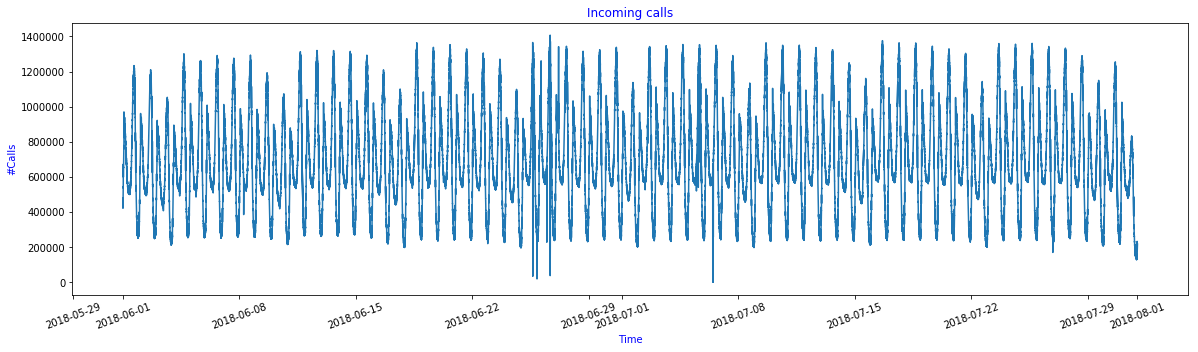

In [13]:
fig = plt.figure(figsize=(20,5))
plt.plot(df_call.loc[df_call.direction == 'incoming'][['time']], df_call.loc[df_call.direction == 'incoming'][['count']], '-', label='Call', markersize=1.0)
plt.xlabel("Time", color='blue')
plt.ylabel("#Calls", color='blue')
plt.xticks(rotation=20)
matplotlib.rc('axes.formatter', useoffset=False)
plt.title("Incoming calls", color='blue')
plt.show()

# <a id='4'>4. Data preprocessing</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [14]:
df_call_train = df_call[df_call['time'] < '2018-07-01']
df_call_val = df_call[df_call['time'] >= '2018-07-01']
df_call_val = df_call_val[df_call_val['time'] < '2018-07-11']
df_call_test = df_call[df_call['time'] >= '2018-07-11']
df_call_test = df_call_test[df_call_test['time'] < '2018-07-21']

In [15]:
print(df_call_train.shape[0])
print(df_call_val.shape[0])
print(df_call_test.shape[0])

86403
28811
28805


In [16]:
df_train = df_call_train.loc[df_call_train.direction == 'incoming']
df_val = df_call_val.loc[df_call_val.direction == 'incoming']
df_test = df_call_test.loc[df_call_test.direction == 'incoming']

In [17]:
call_seq_train = list(df_train['count'])
call_seq_val = list(df_val['count'])
call_seq_test = list(df_test['count'])

In [18]:
print('train size: ', len(call_seq_train))
print('val size: ', len(call_seq_val))
print('test size: ', len(call_seq_test))

train size:  43187
val size:  14399
test size:  14400


### DL Based Preprocessing

In [19]:
# Transfrom univariate time series to supervised problem
def split_univariate_sequence(sequence, n_stpes):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_stpes
        # check if it's beyond the sequence
        if end_ix > len(sequence) - 1:
            break
        # get input and output parts
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# <a id='5'>5. Model Building</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [20]:
algorithms = ['mlp', 'cnn', 'vanilla_lstm', 'stacked_lstm', 'bidirectional_lstm', 'cnn_lstm', 'conv_lstm']

In [21]:
model_json_dir = 'wc_call_model_jsons'
model_weights_dir = 'wc_call_model_weights'
model_hisotries_dir = 'wc_call_model_histories'

In [22]:
# dictionary for storing model json file names for different algorigthms
model_json_files_dict = {}
# dictionary for storing model weight file names for different algorigthms
model_weight_files_dict = {}
# dictionary for storing model weight file names for different algorigthms
model_history_files_dict = {}

In [23]:
for algo in algorithms:
    model_json_files_dict[algo] = os.path.join(model_json_dir, 'in_call_%s.json' %algo)
    model_weight_files_dict[algo] = os.path.join(model_weights_dir, 'in_call_%s.h5' %algo)
    model_history_files_dict[algo] = os.path.join(model_hisotries_dir, 'in_call_%s.json' %algo)

In [24]:
n_features = 1

n_steps = 30 # 30 time steps as input
n_sub_seq = 3 # dividing time steps into 3
n_sub_steps = 10 # 10 steps in each sub sequence

In [25]:
# Preprocessing for DL based analysis
X_train, y_train = split_univariate_sequence(call_seq_train, n_steps)
X_val, y_val = split_univariate_sequence(call_seq_val, n_steps)
X_test, y_test = split_univariate_sequence(call_seq_test, n_steps)

In [26]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(43157, 30) (43157,)
(14369, 30) (14369,)
(14370, 30) (14370,)


In [27]:
# Initializing hyper parameters
activation='relu'
optimizer='adam'
loss='mse'
epochs=10000

In [28]:
class Models(object):
    # keep funciton name format "algo_model"(where 'algo' as in 'algorithm' array) for dynamic calling purpose
    def mlp_model(self, input_dim):
        model = Sequential()
        model.add(Dense(100, activation=activation, input_dim=input_dim))
        model.add(Dense(1))
        return model
    
    def cnn_model(self, input_dim):
        model = Sequential()
        model.add(Conv1D(filters=64, kernel_size=2, activation=activation, input_shape=input_dim))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(Dense(100, activation=activation))
        model.add(Dense(1))
        return model
    
    def vanilla_lstm_model(self, input_dim):
        model = Sequential()
        model.add(LSTM(100, activation=activation, input_shape=input_dim))
        model.add(Dense(1))
        return model
    
    def stacked_lstm_model(self, input_dim):
        model = Sequential()
        model.add(LSTM(100, activation=activation, return_sequences=True, input_shape=input_dim))
        model.add(LSTM(50, activation=activation))
        model.add(Dense(1))
        return model
        
    def bidirectional_lstm_model(self, input_dim):
        model = Sequential()
        model.add(Bidirectional(LSTM(100, activation=activation), input_shape=input_dim))
        model.add(Dense(1))
        return model
        
    def cnn_lstm_model(self, input_dim):
        model = Sequential()
        model.add(TimeDistributed(Conv1D(filters=64, kernel_size=2, activation=activation), input_shape=input_dim))
        model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(100, activation=activation))
        model.add(Dense(1))
        return model
        
    def conv_lstm_model(self, input_dim):
        model = Sequential()
        model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation=activation, input_shape=input_dim))
        model.add(Flatten())
        model.add(Dense(1))
        return model

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [30]:
def train_model(x_train, y_train, x_val, y_val, input_dim, algo, model_json, model_weights, model_history, re_train=False):
    if (os.path.isfile(model_json)):
        with open(model_json, "r") as json_file:
            model = model_from_json(json_file.read())
    else:
        models = Models()
        model_func = getattr(models, '%s_model' %algo)
        model = model_func(input_dim)
        with open(model_json, "w") as json_file:
            json_file.write(model.to_json())

    if ((re_train == True) or (not os.path.isfile(model_weights))):
        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', 'mse', 'mae', 'mape', 'cosine'])
        mc = ModelCheckpoint(model_weights, monitor='val_acc', mode='max', verbose=1, save_best_only=True)
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, verbose=0, callbacks=[es, mc])
        model.save_weights(model_weights)
        with open(model_history, 'w') as f:
            json.dump(hist.history, f)

## <a id='5.1'>5.1. MLP</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [31]:
algo = 'mlp'

In [32]:
X_train_temp = X_train
y_train_temp = y_train
X_val_temp = X_val
y_val_temp = y_val
input_shape = n_steps
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]
model_history = model_history_files_dict[algo]

In [33]:
train_model(X_train_temp, y_train_temp, X_val_temp, y_val_temp, input_shape, algo, model_json, model_history, model_weights)

Instructions for updating:
Colocations handled automatically by placer.


## <a id='5.2'>5.2. CNN</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [34]:
algo = 'cnn'

In [35]:
X_train_temp = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train_temp = y_train
X_val_temp = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
y_val_temp = y_val
input_shape = (n_steps, n_features)
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]
model_history = model_history_files_dict[algo]

In [36]:
train_model(X_train_temp, y_train_temp, X_val_temp, y_val_temp, input_shape, algo, model_json, model_history, model_weights)

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_acc improved from -inf to 0.00000, saving model to wc_call_model_histories/in_call_cnn.json

Epoch 00002: val_acc improved from 0.00000 to 0.00007, saving model to wc_call_model_histories/in_call_cnn.json

Epoch 00003: val_acc did not improve from 0.00007

Epoch 00004: val_acc did not improve from 0.00007

Epoch 00005: val_acc did not improve from 0.00007

Epoch 00006: val_acc improved from 0.00007 to 0.00014, saving model to wc_call_model_histories/in_call_cnn.json

Epoch 00007: val_acc did not improve from 0.00014

Epoch 00008: val_acc did not improve from 0.00014

Epoch 00009: val_acc did not improve from 0.00014

Epoch 00010: val_acc did not improve from 0.00014

Epoch 00011: val_acc did not improve from 0.00014

Epoch 00012: val_acc did not improve from 0.00014

Epoch 00013: val_acc improved from 0.00014 to 0.00021, saving model to wc_call_model_histories/in_call_cnn.json

Epoch 00014: val_acc did not improve from 0

KeyboardInterrupt: 

## <a id='5.3'>5.3. Vanilla LSTM</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [ ]:
algo = 'vanilla_lstm'

In [ ]:
X_train_temp = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train_temp = y_train
X_val_temp = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
y_val_temp = y_val
input_shape = (n_steps, n_features)
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]
model_history = model_history_files_dict[algo]

In [ ]:
train_model(X_train_temp, y_train_temp, X_val_temp, y_val_temp, input_shape, algo, model_json, model_history, model_weights)

## <a id='5.4'>5.4. Stacked LSTM</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [ ]:
algo = 'stacked_lstm'

In [ ]:
X_train_temp = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train_temp = y_train
X_val_temp = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
y_val_temp = y_val
input_shape = (n_steps, n_features)
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]
model_history = model_history_files_dict[algo]

In [ ]:
train_model(X_train_temp, y_train_temp, X_val_temp, y_val_temp, input_shape, algo, model_json, model_history, model_weights)

## <a id='5.5'>5.5. Bidirectional LSTM</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [ ]:
algo = 'bidirectional_lstm'

### Incoming calls

In [ ]:
X_train_temp = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train_temp = y_train
X_val_temp = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
y_val_temp = y_val
input_shape = (n_steps, n_features)
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]
model_history = model_history_files_dict[algo]

In [ ]:
train_model(X_train_temp, y_train_temp, X_val_temp, y_val_temp, input_shape, algo, model_json, model_history, model_weights)

## <a id='5.6'>5.6. CNN-LSTM</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [ ]:
algo = 'cnn_lstm'

In [ ]:
X_train_temp = X_train.reshape((X_train.shape[0], n_sub_seq, n_sub_steps, n_features))
y_train_temp = y_train
X_val_temp = X_val.reshape((X_val.shape[0], n_sub_seq, n_sub_steps, n_features))
y_val_temp = y_val
input_shape = (None, n_sub_steps, n_features)
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]
model_history = model_history_files_dict[algo]

In [ ]:
train_model(X_train_temp, y_train_temp, X_val_temp, y_val_temp, input_shape, algo, model_json, model_history, model_weights)

## <a id='5.7'>5.7. Conv-LSTM</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [ ]:
algo = 'conv_lstm'

In [ ]:
X_train_temp = X_train.reshape((X_train.shape[0], n_sub_seq, 1, n_sub_steps, n_features))
y_train_temp = y_train
X_val_temp = X_val.reshape((X_val.shape[0], n_sub_seq, 1, n_sub_steps, n_features))
y_val_temp = y_val
input_shape = (n_sub_seq, 1, n_sub_steps, n_features)
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]
model_history = model_history_files_dict[algo]

In [ ]:
train_model(X_train_temp, y_train_temp, X_val_temp, y_val_temp, input_shape, algo, model_json, model_history, model_weights)

# <a id='6'>6. Model Performances</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [ ]:
def get_mlp_prediction(model, x_input, input_dim):
    x_input = x_input.reshape((1, input_dim))
    yhat = model.predict(x_input, verbose=0)
    return yhat

def get_cnn_prediction(model, x_input, input_dim, n_features):
    x_input = x_input.reshape((1, input_dim, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

def get_lstm_prediction(model, x_input, input_dim, n_features):
    x_input = x_input.reshape((1, input_dim, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

def get_cnn_lstm_prediction(model, x_input, n_sub_seq, n_sub_steps, n_features):
    x_input = x_input.reshape((1, n_sub_seq, n_sub_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

def get_convlstm_prediction(model, x_input, n_sub_seq, n_sub_steps, n_features):
    x_input = x_input.reshape((1, n_sub_seq, 1, n_sub_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    return yhat

In [ ]:
# dictionaries for predictions key: algorithm value: dataframe(ytrue, yhat)
pred_dict = {} 

In [ ]:
result_dir = 'wc_call_results'

In [ ]:
for algo in algorithms:
    pred_dict[algo] = pd.DataFrame(columns=('ytrue', 'yhat'))

### MLP

In [ ]:
algo = 'mlp'

In [ ]:
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]

In [ ]:
with open(model_json, "r") as json_file:
  model = model_from_json(json_file.read())
model.load_weights(model_weights)

In [ ]:
X = X_test
y = y_test
input_shape = n_steps

In [ ]:
result_file_name = '%s_incall_results.csv' %algo
result_file = os.path.join(result_dir, result_file_name)
if (os.path.isfile(result_file)):
  pred_dict[algo] = pd.read_csv(result_file, sep='\t', header=0, names=['ytrue', 'yhat'])
else:
  for i in range(len(X)):
    ytrue = y[i]
    yhat = get_mlp_prediction(model, X[i], input_shape)
    yhat = round(yhat[0][0])
    pred_dict[algo].loc[i] = [ytrue, yhat]
  pred_dict[algo].to_csv(result_file, sep='\t')

### CNN

In [ ]:
algo = 'cnn'

In [ ]:
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]

In [ ]:
with open(model_json, "r") as json_file:
  model = model_from_json(json_file.read())
model.load_weights(model_weights)

In [ ]:
X = X_test
y = y_test
input_shape = n_steps

In [ ]:
result_file_name = '%s_incall_results.csv' %algo
result_file = os.path.join(result_dir, result_file_name)
if (os.path.isfile(result_file)):
  pred_dict[algo] = pd.read_csv(result_file, sep='\t', header=0, names=['ytrue', 'yhat'])
else:
  for i in range(len(X)):
    ytrue = y[i]
    yhat = get_cnn_prediction(model, X[i], input_shape, n_features)
    yhat = round(yhat[0][0])
    pred_dict[algo].loc[i] = [ytrue, yhat]
  pred_dict[algo].to_csv(result_file, sep='\t')

### Vanilla LSTM

In [ ]:
algo = 'vanilla_lstm'

In [ ]:
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]

In [ ]:
with open(model_json, "r") as json_file:
  model = model_from_json(json_file.read())
model.load_weights(model_weights)

In [ ]:
X = X_test
y = y_test
input_shape = n_steps

In [ ]:
result_file_name = '%s_incall_results.csv' %algo
result_file = os.path.join(result_dir, result_file_name)
if (os.path.isfile(result_file)):
  pred_dict[algo] = pd.read_csv(result_file, sep='\t', header=0, names=['ytrue', 'yhat'])
else:
  for i in range(len(X)):
    ytrue = y[i]
    yhat = get_lstm_prediction(model, X[i], input_shape, n_features)
    yhat = round(yhat[0][0])
    pred_dict[algo].loc[i] = [ytrue, yhat]
  pred_dict[algo].to_csv(result_file, sep='\t')

### Stacked LSTM

In [ ]:
algo = 'stacked_lstm'

In [ ]:
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]

In [ ]:
with open(model_json, "r") as json_file:
  model = model_from_json(json_file.read())
model.load_weights(model_weights)

In [ ]:
X = X_test
y = y_test
input_shape = n_steps

In [ ]:
result_file_name = '%s_incall_results.csv' %algo
result_file = os.path.join(result_dir, result_file_name)
if (os.path.isfile(result_file)):
  pred_dict[algo] = pd.read_csv(result_file, sep='\t', header=0, names=['ytrue', 'yhat'])
else:
  for i in range(len(X)):
    ytrue = y[i]
    yhat = get_lstm_prediction(model, X[i], input_shape, n_features)
    yhat = round(yhat[0][0])
    pred_dict[algo].loc[i] = [ytrue, yhat]
  pred_dict[algo].to_csv(result_file, sep='\t')

### Bidirectional LSTM

In [ ]:
algo = 'bidirectional_lstm'

In [ ]:
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]

In [ ]:
with open(model_json, "r") as json_file:
  model = model_from_json(json_file.read())
model.load_weights(model_weights)

In [ ]:
X = X_test
y = y_test
input_shape = n_steps

In [ ]:
result_file_name = '%s_incall_results.csv' %algo
result_file = os.path.join(result_dir, result_file_name)
if (os.path.isfile(result_file)):
  pred_dict[algo] = pd.read_csv(result_file, sep='\t', header=0, names=['ytrue', 'yhat'])
else:
  for i in range(len(X)):
    ytrue = y[i]
    yhat = get_lstm_prediction(model, X[i], input_shape, n_features)
    yhat = round(yhat[0][0])
    pred_dict[algo].loc[i] = [ytrue, yhat]
  pred_dict[algo].to_csv(result_file, sep='\t')

### CNN-LSTM

In [ ]:
algo = 'cnn_lstm'

In [ ]:
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]

In [ ]:
with open(model_json, "r") as json_file:
  model = model_from_json(json_file.read())
model.load_weights(model_weights)

In [ ]:
X = X_test
y = y_test
input_shape = n_steps

In [ ]:
result_file_name = '%s_incall_results.csv' %algo
result_file = os.path.join(result_dir, result_file_name)
if (os.path.isfile(result_file)):
  pred_dict[algo] = pd.read_csv(result_file, sep='\t', header=0, names=['ytrue', 'yhat'])
else:
  for i in range(len(X)):
    ytrue = y[i]
    yhat = get_cnn_lstm_prediction(model, X[i], n_sub_seq, n_sub_steps, n_features)
    yhat = round(yhat[0][0])
    pred_dict[algo].loc[i] = [ytrue, yhat]
  pred_dict[algo].to_csv(result_file, sep='\t')

### Conv-LSTM

In [ ]:
algo = 'conv_lstm'

In [ ]:
model_json = model_json_files_dict[algo]
model_weights = model_weight_files_dict[algo]

In [ ]:
with open(model_json, "r") as json_file:
  model = model_from_json(json_file.read())
model.load_weights(model_weights)

In [ ]:
X = X_test
y = y_test
input_shape = n_steps

In [ ]:
result_file_name = '%s_incall_results.csv' %algo
result_file = os.path.join(result_dir, result_file_name)
if (os.path.isfile(result_file)):
  pred_dict[algo] = pd.read_csv(result_file, sep='\t', header=0, names=['ytrue', 'yhat'])
else:
  for i in range(len(X)):
    ytrue = y[i]
    yhat = get_convlstm_prediction(model, X[i], n_sub_seq, n_sub_steps, n_features)
    yhat = round(yhat[0][0])
    pred_dict[algo].loc[i] = [ytrue, yhat]
  pred_dict[algo].to_csv(result_file, sep='\t')

## <a id='6.1'>6.1. Model performance metrics</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [ ]:
def get_MAE(y_true, y_pred):
    return round(mean_absolute_error(y_true, y_pred))

def get_MSE(y_true, y_pred):
    return round(mean_squared_error(y_true, y_pred), 2)

def get_RMSE(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)

def get_MAPE(y_true, y_pred):
    ##return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)
    return float(Decimal(str(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)).quantize(Decimal('0.001'), rounding=ROUND_DOWN))
  
def get_CosineProximity(y_true, y_pred):
    return float(Decimal(str(cosine_similarity([y_true], [y_pred])[0][0])).quantize(Decimal('0.00001'), rounding=ROUND_DOWN))

In [ ]:
model_perf_df = pd.DataFrame(columns=('Algorithm', 'MAE', 'MSE', 'RMSE', 'MAPE', 'Cosine_Proximity'))

In [ ]:
for algo in algorithms:
  row = list()
  row.append(algo)
  y_true = pred_dict[algo]['ytrue'].values
  y_pred = pred_dict[algo]['yhat'].values
  row.append(get_MAE(y_true, y_pred))
  row.append(get_MSE(y_true, y_pred))
  row.append(get_RMSE(y_true, y_pred))
  row.append(get_MAPE(y_true, y_pred))
  row.append(get_CosineProximity(y_true, y_pred))
  model_perf_df.loc[len(model_perf_df)] = row

## <a id='6.2'>6.2. Compare model metrics</a>
<div style="text-align: right"><a href='#1234'>Table of Contents</a></div>

In [ ]:
model_perf_df